# Book part

Models performance will be measured in terms of RMSE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv('datasets/housing.csv')

Initial descriptive stats:

In [4]:
print(data.head())
print(data.describe())
print(data.info())
print(data.isnull().sum())
print(data['total_bedrooms'].isnull().sum() / len(data['total_bedrooms']))

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
          longitude      latitude  housing_median_age   total_rooms  \
coun

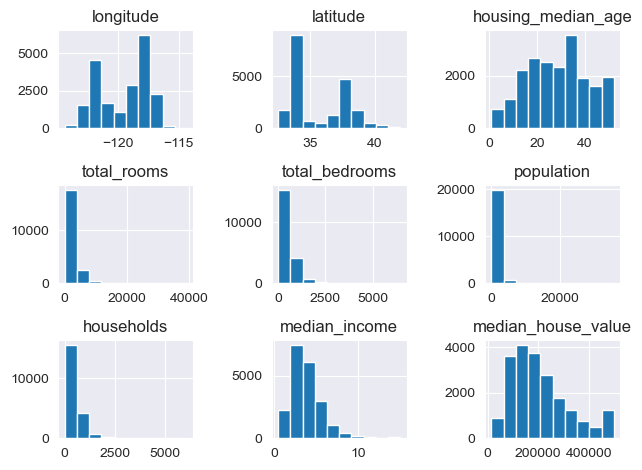

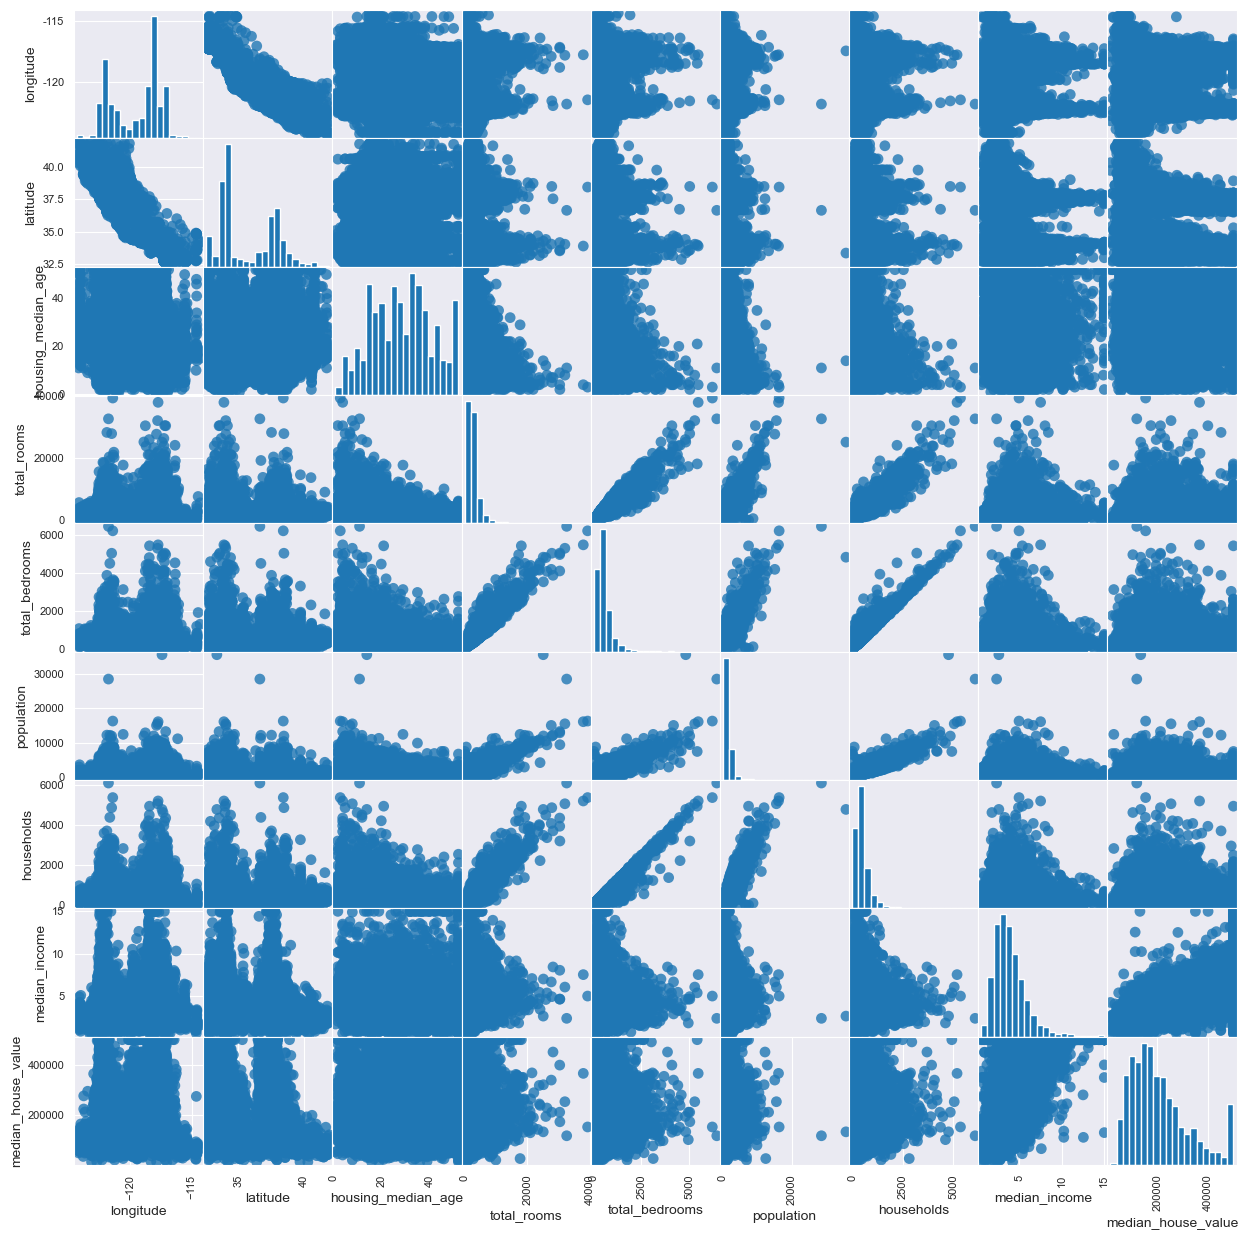

In [5]:
_ = data.hist()

plt.tight_layout()

_ = pd.plotting.scatter_matrix(
    data,
    figsize=(15, 15),
    marker='o',
    hist_kwds={'bins': 20},
    s=60,
    alpha=.8)

In [6]:
def fillna(dat):
    nxt = dat.copy()
    nxt['total_bedrooms'] = dat['total_bedrooms'].fillna(dat['total_bedrooms'].median())

    return nxt


data_copy = fillna(data)

In [7]:
data_copy.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
data_copy.drop(['latitude', 'longitude'], axis=1).corr()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
housing_median_age,1.000000,-0.361262,-0.319026,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,-0.361262,1.000000,0.927058,0.857126,0.918484,0.198050,0.134153
total_bedrooms,-0.319026,0.927058,1.000000,0.873535,0.974366,-0.007617,0.049457
population,-0.296244,0.857126,0.873535,1.000000,0.907222,0.004834,-0.024650
households,-0.302916,0.918484,0.974366,0.907222,1.000000,0.013033,0.065843
median_income,-0.119034,0.198050,-0.007617,0.004834,0.013033,1.000000,0.688075
median_house_value,0.105623,0.134153,0.049457,-0.024650,0.065843,0.688075,1.000000


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

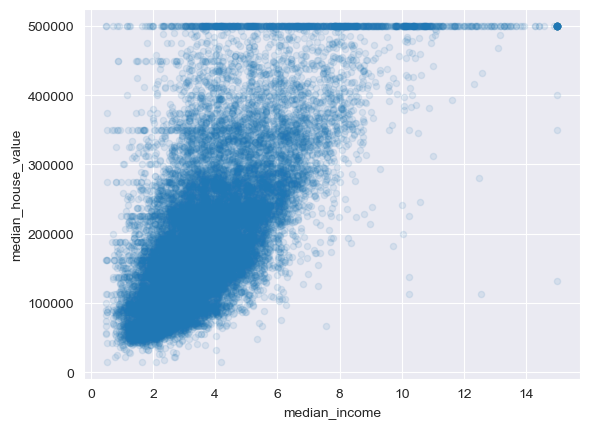

In [9]:
data_copy.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.1)

In [10]:
data_copy['rooms_per_family'] = data_copy['total_rooms'] / data_copy['households']
data_copy['bedrooms_per_family'] = data_copy['total_bedrooms'] / data_copy['households']

data_copy.drop(['total_rooms', 'total_bedrooms'], axis=1, inplace=True)
data_copy.corr()['median_house_value'].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688075
rooms_per_family       0.151948
housing_median_age     0.105623
households             0.065843
population            -0.024650
bedrooms_per_family   -0.045637
longitude             -0.045967
latitude              -0.144160
Name: median_house_value, dtype: float64

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


num_attrs = data_copy.drop(['median_house_value', 'ocean_proximity'], axis=1).columns.tolist()
cat_attrs = ['ocean_proximity']
pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attrs),
    ('cat', OneHotEncoder(), cat_attrs)
])
ready_data = pipeline.fit_transform(data_copy.drop('median_house_value', axis=1))

X_train, X_test, y_train, y_test = train_test_split(
    ready_data,
    data_copy['median_house_value'],
    random_state=42,
    test_size=.3)

Initial guess - linear regression

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


reg = LinearRegression()

reg.fit(X_train, y_train)

predictions = reg.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)

mse

71628.82250708358

Second guess - random forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


params = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 4, 6]}
]
forest = RandomForestRegressor()
grid = GridSearchCV(
    forest,
    param_grid=params,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True)

grid.fit(X_train, y_train)

grid.best_params_

{'max_features': 8, 'n_estimators': 30}

In [14]:
predictions = grid.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)

mse

49634.394025124864

Calculating confidence intervals

In [15]:
from scipy import stats


CONF = .95
sq_errors = (predictions - y_test) ** 2

np.sqrt(stats.t.interval(CONF, len(sq_errors) - 1, loc=sq_errors.mean(), scale=stats.sem(sq_errors)))

array([47824.37780296, 51380.687308  ])

# Homework

Third guess - SVM regressor

In [16]:
from sklearn.svm import SVR


svm_reg = SVR(kernel='poly')

svm_reg.fit(X_train, y_train)

predictions = svm_reg.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)

mse

117823.63893558076

Text(0, 0.5, 'Variance Explained')

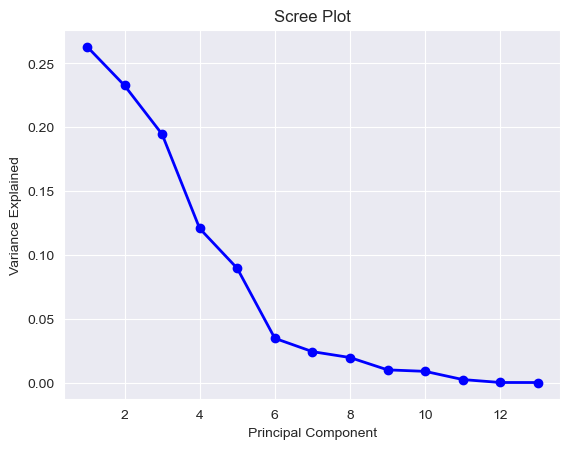

In [17]:
from sklearn.decomposition import PCA


pca = PCA()

pca.fit_transform(X_test, y_test)

plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

In [18]:
pca_final = PCA(n_components=6)
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)
reg_final = LinearRegression()
forest_final = RandomForestRegressor(max_features=6, n_estimators=30)

reg_final.fit(X_train_pca, y_train)
forest_final.fit(X_train_pca, y_train)

reg_predictions_final = reg_final.predict(X_test_pca)
forest_predictions_final = forest_final.predict(X_test_pca)
mse_reg_final = mean_squared_error(y_test, reg_predictions_final, squared=False)
mse_forest_final = mean_squared_error(y_test, forest_predictions_final, squared=False)

print(mse_reg_final, mse_forest_final)

75134.73423267447 66910.46145590444


In [19]:
forest_searched = RandomForestRegressor()
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5]
}
grid_final = GridSearchCV(
    forest_searched,
    param_grid=params,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True)

grid.fit(X_train_pca, y_train)

predictions_searched = grid.best_estimator_.predict(X_test_pca)

mean_squared_error(y_test, predictions_searched, squared=False)

66928.51257616935